<h1 align="center">  Генерация подписей к изображениям Image captioning </h1>

![img](https://i.imgur.com/obITaMl.png)



#### План:
1. Взять предобученный inception v3 и получить эмбеддинги картинок
2. Подать их на вход LSTM
3. Обучить это на [MSCOCO](http://cocodataset.org/#download)

In [0]:
# Скачайте данные с https://yadi.sk/d/b4nAwIE73TVcp5

Команда распаковать архив *tar.gz:

In [7]:
!tar -xvzf handout.tar.gz

data/
data/captions_tokenized.json
data/image_codes.npy

gzip: stdin: unexpected end of file
tar: Unexpected EOF in archive
tar: Unexpected EOF in archive
tar: Error is not recoverable: exiting now


### Препроцессинг данных

In [0]:
%%time
# Read Dataset
import numpy as np
import json

img_codes = np.load("data/image_codes.npy")
captions = json.load(open('data/captions_tokenized.json'))

### Data structure

Чтобы сохранить ваше время картинки из MSCOCO17 были векторизованы моделью  inception_v3 из библиотеки [torchvision](https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py).

[Если вы хотите использовать другую модель, вы можете сделать это самостоятельно](https://gist.github.com/justheuristic/11fd01f9c12c0bf960499580d104130b).

In [0]:
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


Все описания уже почищены и преведены к нижнему регистру. Осталось разделить их на слова и добавить токены для конца и начала предложения.

In [0]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]

Чтобы нашей LSTM было не пришлось сэмплить вектора вероятностей огромной длины, нам придется уменьшить размер словаря.

Посчитайте __частоту встречаемости каждого слова__ чтобы принять решение какие слова оставить в словаре.

In [0]:
# Build a Vocabulary
from collections import Counter
word_counts = Counter()

# Compute word frequencies for each word in captions. See code above for data structure
# <YOUR CODE HERE>


In [0]:
vocab  = ['#UNK#', '#START#', '#END#', '#PAD#']
MIN_COUNT = <YOUR CODE HERE>
vocab += [k for k, v in word_counts.items() if v >= MIN_COUNT if k not in vocab]
n_tokens = len(vocab)

# Оставьте от 10000 до 10500 слов в словаре
assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [0]:
eos_ix = word_to_index['#END#']
unk_ix = word_to_index['#UNK#']
pad_ix = word_to_index['#PAD#']

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    return matrix

In [0]:
#try it out on several descriptions of a random image
as_matrix(captions[1337])

array([[   1, 2227, 2125, 8839, 1183, 7009, 5310, 2227, 6666, 7234, 7406,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1, 2227, 2125, 2052, 2358, 2227, 6666, 7234,    2,    3,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1, 2227, 2125, 7680, 2358, 9558, 9910, 4485, 7234,    2,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1, 3673, 3314, 2125, 7680, 2052, 2358, 4485,  203, 6800, 7406,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1, 2227, 2125, 2052, 2358, 2227, 6666, 5457, 9428, 3673, 2616,
        1022, 2227, 6819, 9910, 3673, 9700, 7406,    2]], dtype=int32)

### Построение нейронной сети

Нам нужно сообщить RNN о картинке - для этого на вход подадим эмбеддинг картинки - то есть выход предпоследнего слоя модели, обрабатывающей картинку. 

![img](https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png)
_image: http://bit.ly/2FKnqHm_




In [0]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [0]:
class CaptionNet(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=128, lstm_units=256, cnn_feature_size=2048):
        """ A recurrent 'head' network for image captioning. See scheme above. """
        super(self.__class__, self).__init__()

        # a layer that converts conv features to
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units)

        self.cnn_upd_c = nn.Linear(cnn_feature_size, lstm_units)

        # recurrent part, please create the layers as per scheme above.

        # create embedding for input words. Use the parameters (e.g. emb_size).
        self.emb = # YOUR CODE

        # lstm: create a recurrent core of your network. Use either LSTMCell or just LSTM.
        # In the latter case (nn.LSTM), make sure batch_first=True
        self.lstm_cell = # YOUR CODE

        # create logits: linear layer that takes lstm hidden state as input and computes one number per token
        self.logits = # YOUR CODE

    def forward(self, image_vectors, captions_ix):
        """
        Apply the network in training mode.
        :param image_vectors: torch tensor containing inception vectors.
        shape: [batch,cnn_feature_size]
        :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
            padded with pad_ix
        :returns: logits for next token at each tick, shape: [batch, word_i, n_tokens]
        """

        # apply recurrent layer to captions_emb. 
        # 1. initialize lstm state with initial_* from above
        # 2. feed it with captions. Mind the dimension order in docstring
        # 3. compute logits for next token probabilities
        # Note: if you used nn.LSTM, you can just give it (initial_cell[None], initial_hid[None])
        #  as second arg

        # lstm_out should be lstm hidden state sequence of shape [batch, caption_length, lstm_units]
        # compute logits from lstm_out

        initial_cell = self.cnn_to_c0(image_vectors)
        initial_hid = self.cnn_to_h0(image_vectors)

        # compute embeddings for captions_ix
        captions_emb = self.emb(captions_ix)
        
        lstm_out = []
        next_hid  = initial_hid
        next_cell = initial_cell
        img_upd_cell = F.sigmoid(self.cnn_upd_c(image_vectors))
        for x_t in captions_emb.transpose(0,1):
            hidden, cell = # YOUR CODE
  
            next_hid = hidden
            next_cell = (img_upd_cell) + cell
            lstm_out.append(hidden)
        lstm_out = torch.stack(lstm_out, dim=1)
        logits = self.logits(lstm_out)
        return logits

In [0]:
network = CaptionNet(n_tokens, lstm_units=512, emb_size=256)

In [0]:
as_matrix(captions[0]).shape

(5, 16)

In [0]:
dummy_img_vec = torch.randn(len(captions[0]), 2048)
dummy_capt_ix = torch.tensor(as_matrix(captions[0]), dtype=torch.int64)

dummy_logits = network.forward(dummy_img_vec, dummy_capt_ix)

print('shape:', dummy_logits.shape)
assert dummy_logits.shape == (dummy_capt_ix.shape[0], dummy_capt_ix.shape[1], n_tokens)

shape: torch.Size([5, 16, 10403])


In [0]:
def compute_loss(network, image_vectors, captions_ix):
    """
    :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
    :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
        padded with pad_ix
    :returns: scalar crossentropy loss (neg llh) loss for next captions_ix given previous ones
    """

    # captions for input - all except last cuz we don't know next token for last one.
    captions_ix_inp = captions_ix[:, :-1].contiguous().cuda()
    captions_ix_next = captions_ix[:, 1:].contiguous().cuda()

    # apply the network, get predictions for captions_ix_next
    logits_for_next = network.cuda().forward(image_vectors.cuda(), captions_ix_inp)


    # compute the loss function between logits_for_next and captions_ix_next
    # Use the mask, Luke: make sure that predicting next tokens after EOS do not contribute to loss
    # you can do that either by multiplying elementwise loss by (captions_ix_next != pad_ix)
    # or by using ignore_index in some losses.

    ce_loss = nn.CrossEntropyLoss(ignore_index=pad_ix)
    loss = ce_loss(torch.transpose(logits_for_next, 2, 1), captions_ix_next)
    return loss.reshape(-1)

In [0]:
dummy_loss = compute_loss(network, dummy_img_vec, dummy_capt_ix)
print(dummy_loss)

assert dummy_loss.shape == torch.Size([1]), 'loss must be scalar'
assert dummy_loss.cpu().data.numpy() > 0, "did you forget the 'negative' part of negative log-likelihood"

dummy_loss.backward()

assert all(param.grad is not None for param in network.parameters()), \
        'loss should depend differentiably on all neural network weights'

tensor([9.2895], device='cuda:0', grad_fn=<AsStridedBackward>)


Создайте оптимизатор для нейронной сети.

In [0]:
opt = torch.optim.Adam(network.parameters(), lr=1e-3)

# Обучение

* Сначала создадим генератор батчей
* Обучим сеть (как обычно)

In [0]:
from sklearn.model_selection import train_test_split
captions = np.array(captions)
train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(img_codes, captions,
                                                                                test_size=0.1,
                                                                                random_state=42)

In [0]:
from random import choice

def generate_batch(img_codes, captions, batch_size, max_caption_len=None):

    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)

    #get images
    batch_images = img_codes[random_image_ix]

    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick one from a set of captions for each image
    batch_captions = list(map(choice,captions_for_batch_images))

    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return torch.tensor(batch_images, dtype=torch.float32), torch.tensor(batch_captions_ix, dtype=torch.int64)
    

In [0]:
generate_batch(img_codes,captions,3)

(tensor([[0.3335, 0.3121, 0.3083,  ..., 0.5208, 0.6801, 0.5232],
         [0.3640, 1.3318, 0.1158,  ..., 1.2809, 1.3662, 0.5316],
         [0.1706, 0.3683, 0.1228,  ..., 0.1297, 0.1316, 0.0202]]),
 tensor([[   1, 3673, 5666, 7061, 6202,  432, 9428, 5711, 4513, 8028, 3867, 7406,
             2,    3],
         [   1,  296, 9910, 2227, 4242, 7108,  657, 6167, 5916, 6598, 7406,    2,
             3,    3],
         [   1, 2227, 5357, 1183, 3673, 4629, 8885,  100, 4009, 1820, 3673, 6301,
          7406,    2]]))

### Главный цикл обучения

Обучите сеть на мини-батчах как обычно. Считайте лосс на валидации в конце каждой эпохи.

##### Подсказки
* Если модель предсказывает непонятную ерунду, проверьте, что вы предсказываете
     __следующее словао__ words, а не несколько следующих слов.
* Если модель генерирует понятные описания, которые не имеют ничего общего с картинкой:
 * Может быть ваша RNN не получает эмбеддинг картинки.
 * Может быть, у вас взорвались градиенты, можно попробовать [gradient clipping](https://stackoverflow.com/questions/54716377/how-to-do-gradient-clipping-in-pytorch) или начните обучение заново.
 * И наконец, возможно нужно дольше обучать модель.


* Кросс-энтропия не показательна для оценки качества генерации текстов, то есть при одинаковом значении кросс-энтропии качество описаний может сильно отличаться.

 * Проверяйте осмысленность подписей вручную или почитайте о специальных метриках для текстов [cider](https://github.com/vrama91/cider) or [bleu](https://www.nltk.org/_modules/nltk/translate/bleu_score.html)
 

 *  Время от времени можно останавливать обучение, проверять на нескольких примерах и затем продолжать обучение.

* Адекватные описания появляются, когда loss=2.8 ~ 3.0
 

In [0]:
batch_size = 50  # adjust me
n_epochs = 100  # adjust me
n_batches_per_epoch = 50  # adjust me
n_validation_batches = 5  # how many batches are used for validation after each epoch

In [0]:
# from collections import defaultdict
train_loss_history = []
val_loss_history   = []

In [0]:
from tqdm import tqdm

for epoch in range(n_epochs):
    
    train_loss=0
    network.train(True)
    for _ in tqdm(range(n_batches_per_epoch)):
        
        loss_t = compute_loss(network, *generate_batch(train_img_codes, train_captions, batch_size))
        
        
        # clear old gradients; do a backward pass to get new gradients; then train with opt
        # YOUR CODE
        # YOUR CODE
        # YOUR CODE

          
        train_loss += loss_t.item()
        
    train_loss /= n_batches_per_epoch
    train_loss_history.append(train_loss)

    val_loss=0
    network.train(False)
    for _ in range(n_validation_batches):
        loss_t = compute_loss(network, *generate_batch(val_img_codes, val_captions, batch_size))
        val_loss += loss_t.item()
    val_loss /= n_validation_batches
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))
    val_loss_history.append(val_loss)

print("Finished!")

  8%|▊         | 4/50 [00:00<00:01, 33.47it/s]


Epoch: 0, train loss: 5.555752544403076, val loss: 4.680522727966308


  8%|▊         | 4/50 [00:00<00:01, 32.82it/s]


Epoch: 1, train loss: 4.576383190155029, val loss: 4.467304420471192


  8%|▊         | 4/50 [00:00<00:01, 36.34it/s]


Epoch: 2, train loss: 4.26179826259613, val loss: 4.160073375701904


  8%|▊         | 4/50 [00:00<00:01, 37.77it/s]


Epoch: 3, train loss: 4.076020936965943, val loss: 3.933493900299072


  8%|▊         | 4/50 [00:00<00:01, 37.92it/s]


Epoch: 4, train loss: 3.9074453783035277, val loss: 3.879451131820679


 10%|█         | 5/50 [00:00<00:01, 40.10it/s]


Epoch: 5, train loss: 3.721865873336792, val loss: 3.7057709217071535


  8%|▊         | 4/50 [00:00<00:01, 32.98it/s]


Epoch: 6, train loss: 3.5956986141204834, val loss: 3.6120498180389404


  6%|▌         | 3/50 [00:00<00:01, 24.64it/s]


Epoch: 7, train loss: 3.539926781654358, val loss: 3.5481987953186036


 10%|█         | 5/50 [00:00<00:01, 40.89it/s]


Epoch: 8, train loss: 3.442595658302307, val loss: 3.496305227279663


  8%|▊         | 4/50 [00:00<00:01, 30.81it/s]


Epoch: 9, train loss: 3.378319149017334, val loss: 3.3460395336151123


  6%|▌         | 3/50 [00:00<00:01, 28.29it/s]


Epoch: 10, train loss: 3.3110820293426513, val loss: 3.3987144470214843


  6%|▌         | 3/50 [00:00<00:01, 27.56it/s]


Epoch: 11, train loss: 3.2271751070022585, val loss: 3.3157896518707277


 10%|█         | 5/50 [00:00<00:01, 43.00it/s]


Epoch: 12, train loss: 3.2164270544052123, val loss: 3.387302303314209


  8%|▊         | 4/50 [00:00<00:01, 33.16it/s]


Epoch: 13, train loss: 3.173997468948364, val loss: 3.2014840602874757


  8%|▊         | 4/50 [00:00<00:01, 32.19it/s]


Epoch: 14, train loss: 3.1403378582000734, val loss: 3.182771348953247


 10%|█         | 5/50 [00:00<00:01, 38.78it/s]


Epoch: 15, train loss: 3.061837239265442, val loss: 3.090506935119629


 10%|█         | 5/50 [00:00<00:01, 40.77it/s]


Epoch: 16, train loss: 3.1114064502716063, val loss: 3.165920352935791


  8%|▊         | 4/50 [00:00<00:01, 37.17it/s]


Epoch: 17, train loss: 3.052189898490906, val loss: 3.1135746002197267


  8%|▊         | 4/50 [00:00<00:01, 33.59it/s]


Epoch: 18, train loss: 3.0315681219100954, val loss: 2.9851358413696287


  6%|▌         | 3/50 [00:00<00:01, 26.93it/s]


Epoch: 19, train loss: 3.021591157913208, val loss: 2.93499641418457


  8%|▊         | 4/50 [00:00<00:01, 38.75it/s]


Epoch: 20, train loss: 3.038128614425659, val loss: 2.946358823776245


  8%|▊         | 4/50 [00:00<00:01, 37.08it/s]


Epoch: 21, train loss: 3.000938949584961, val loss: 2.8886179447174074


  8%|▊         | 4/50 [00:00<00:01, 31.91it/s]


Epoch: 22, train loss: 2.924150071144104, val loss: 2.963816928863525


  8%|▊         | 4/50 [00:00<00:01, 35.70it/s]


Epoch: 23, train loss: 2.9549681758880615, val loss: 3.010723114013672


  8%|▊         | 4/50 [00:00<00:01, 33.74it/s]


Epoch: 24, train loss: 2.878055257797241, val loss: 2.9078267097473143


  6%|▌         | 3/50 [00:00<00:01, 28.60it/s]


Epoch: 25, train loss: 2.9290277194976806, val loss: 3.008256959915161


  8%|▊         | 4/50 [00:00<00:01, 31.39it/s]


Epoch: 26, train loss: 2.919309253692627, val loss: 2.8926384925842283


  8%|▊         | 4/50 [00:00<00:01, 32.75it/s]


Epoch: 27, train loss: 2.8870179224014283, val loss: 3.0054104328155518


  8%|▊         | 4/50 [00:00<00:01, 37.56it/s]


Epoch: 28, train loss: 2.851288151741028, val loss: 2.8477610111236573


  8%|▊         | 4/50 [00:00<00:01, 39.38it/s]


Epoch: 29, train loss: 2.899538698196411, val loss: 2.858105707168579


  8%|▊         | 4/50 [00:00<00:01, 35.90it/s]


Epoch: 30, train loss: 2.8492595672607424, val loss: 2.77219557762146


  8%|▊         | 4/50 [00:00<00:01, 29.62it/s]


Epoch: 31, train loss: 2.8409390687942504, val loss: 2.857795000076294


 10%|█         | 5/50 [00:00<00:01, 38.43it/s]


Epoch: 32, train loss: 2.797809624671936, val loss: 2.831938457489014


  6%|▌         | 3/50 [00:00<00:01, 29.75it/s]


Epoch: 33, train loss: 2.8268710565567017, val loss: 2.728443717956543


  6%|▌         | 3/50 [00:00<00:01, 28.01it/s]


Epoch: 34, train loss: 2.7988698196411135, val loss: 2.891426753997803


  8%|▊         | 4/50 [00:00<00:01, 31.85it/s]


Epoch: 35, train loss: 2.790160608291626, val loss: 2.7319478511810305


  8%|▊         | 4/50 [00:00<00:01, 32.46it/s]


Epoch: 36, train loss: 2.80968141078949, val loss: 2.7897261142730714


  8%|▊         | 4/50 [00:00<00:01, 35.72it/s]


Epoch: 37, train loss: 2.8062790298461913, val loss: 2.7872870445251463


 10%|█         | 5/50 [00:00<00:01, 38.14it/s]


Epoch: 38, train loss: 2.7491986894607545, val loss: 2.825858497619629


  8%|▊         | 4/50 [00:00<00:01, 36.02it/s]


Epoch: 39, train loss: 2.7255930709838867, val loss: 2.759647178649902


  8%|▊         | 4/50 [00:00<00:01, 36.55it/s]


Epoch: 40, train loss: 2.7862047433853148, val loss: 2.7856439113616944


  8%|▊         | 4/50 [00:00<00:01, 38.03it/s]


Epoch: 41, train loss: 2.7385391187667847, val loss: 2.7980164527893066


  8%|▊         | 4/50 [00:00<00:01, 33.74it/s]


Epoch: 42, train loss: 2.728093366622925, val loss: 2.7390342712402345


  8%|▊         | 4/50 [00:00<00:01, 37.94it/s]


Epoch: 43, train loss: 2.7147990560531614, val loss: 2.7934178352355956


  8%|▊         | 4/50 [00:00<00:01, 39.94it/s]


Epoch: 44, train loss: 2.731066861152649, val loss: 2.7387708187103272


 10%|█         | 5/50 [00:00<00:01, 41.35it/s]


Epoch: 45, train loss: 2.7298775339126586, val loss: 2.707452964782715


  8%|▊         | 4/50 [00:00<00:01, 32.65it/s]


Epoch: 46, train loss: 2.7306889295578003, val loss: 2.832925796508789


  8%|▊         | 4/50 [00:00<00:01, 34.07it/s]


Epoch: 47, train loss: 2.6944788217544557, val loss: 2.670441246032715


  8%|▊         | 4/50 [00:00<00:01, 37.48it/s]


Epoch: 48, train loss: 2.684261722564697, val loss: 2.702534627914429


  8%|▊         | 4/50 [00:00<00:01, 35.44it/s]


Epoch: 49, train loss: 2.6990042686462403, val loss: 2.660781002044678


  8%|▊         | 4/50 [00:00<00:01, 32.34it/s]


Epoch: 50, train loss: 2.7087099742889404, val loss: 2.783000612258911


  6%|▌         | 3/50 [00:00<00:01, 26.71it/s]


Epoch: 51, train loss: 2.6754763555526733, val loss: 2.822200965881348


  8%|▊         | 4/50 [00:00<00:01, 39.33it/s]


Epoch: 52, train loss: 2.6723720979690553, val loss: 2.718485450744629


  8%|▊         | 4/50 [00:00<00:01, 29.97it/s]


Epoch: 53, train loss: 2.6552522706985475, val loss: 2.674023675918579


  8%|▊         | 4/50 [00:00<00:01, 38.36it/s]


Epoch: 54, train loss: 2.6729430246353147, val loss: 2.6617198467254637


  8%|▊         | 4/50 [00:00<00:01, 38.32it/s]


Epoch: 55, train loss: 2.6517606925964357, val loss: 2.665426731109619


  8%|▊         | 4/50 [00:00<00:01, 33.04it/s]


Epoch: 56, train loss: 2.633171057701111, val loss: 2.7626067638397216


  8%|▊         | 4/50 [00:00<00:01, 38.53it/s]


Epoch: 57, train loss: 2.6273602867126464, val loss: 2.7392176151275636


  8%|▊         | 4/50 [00:00<00:01, 33.61it/s]


Epoch: 58, train loss: 2.63225839138031, val loss: 2.6928971290588377


  8%|▊         | 4/50 [00:00<00:01, 32.40it/s]


Epoch: 59, train loss: 2.636097092628479, val loss: 2.7151817798614504


  8%|▊         | 4/50 [00:00<00:01, 38.67it/s]


Epoch: 60, train loss: 2.644720959663391, val loss: 2.6379995822906492


  8%|▊         | 4/50 [00:00<00:01, 35.54it/s]


Epoch: 61, train loss: 2.6080785274505613, val loss: 2.6614824295043946


  8%|▊         | 4/50 [00:00<00:01, 29.19it/s]


Epoch: 62, train loss: 2.654255018234253, val loss: 2.6927218437194824


  8%|▊         | 4/50 [00:00<00:01, 32.59it/s]


Epoch: 63, train loss: 2.6345803260803224, val loss: 2.6088311195373537


  8%|▊         | 4/50 [00:00<00:01, 30.14it/s]


Epoch: 64, train loss: 2.6017363977432253, val loss: 2.667826461791992


 10%|█         | 5/50 [00:00<00:01, 40.98it/s]


Epoch: 65, train loss: 2.5962057590484617, val loss: 2.6484922409057616


  8%|▊         | 4/50 [00:00<00:01, 32.67it/s]


Epoch: 66, train loss: 2.6163639974594117, val loss: 2.6759081840515138


  8%|▊         | 4/50 [00:00<00:01, 28.62it/s]


Epoch: 67, train loss: 2.5949586629867554, val loss: 2.5684344291687013


  6%|▌         | 3/50 [00:00<00:02, 22.95it/s]


Epoch: 68, train loss: 2.5993456840515137, val loss: 2.633808469772339


  8%|▊         | 4/50 [00:00<00:01, 38.58it/s]


Epoch: 69, train loss: 2.609399747848511, val loss: 2.60390887260437


 10%|█         | 5/50 [00:00<00:01, 40.96it/s]


Epoch: 70, train loss: 2.6116779899597167, val loss: 2.652484655380249


 10%|█         | 5/50 [00:00<00:01, 41.50it/s]


Epoch: 71, train loss: 2.60479088306427, val loss: 2.6681049823760987


  8%|▊         | 4/50 [00:00<00:01, 31.79it/s]


Epoch: 72, train loss: 2.614729890823364, val loss: 2.769036293029785


  8%|▊         | 4/50 [00:00<00:01, 31.39it/s]


Epoch: 73, train loss: 2.605937762260437, val loss: 2.5549458980560305


  8%|▊         | 4/50 [00:00<00:01, 38.83it/s]


Epoch: 74, train loss: 2.5886244583129883, val loss: 2.5983893394470217


  8%|▊         | 4/50 [00:00<00:01, 34.74it/s]


Epoch: 75, train loss: 2.589988121986389, val loss: 2.660413885116577


 10%|█         | 5/50 [00:00<00:01, 41.82it/s]


Epoch: 76, train loss: 2.590441117286682, val loss: 2.63048677444458


  8%|▊         | 4/50 [00:00<00:01, 34.31it/s]


Epoch: 77, train loss: 2.62151017665863, val loss: 2.6497278690338133


  8%|▊         | 4/50 [00:00<00:01, 30.89it/s]


Epoch: 78, train loss: 2.555126442909241, val loss: 2.6160614490509033


  8%|▊         | 4/50 [00:00<00:01, 35.32it/s]


Epoch: 79, train loss: 2.544057002067566, val loss: 2.542042064666748


  6%|▌         | 3/50 [00:00<00:01, 26.70it/s]


Epoch: 80, train loss: 2.532023506164551, val loss: 2.6597025871276854


  8%|▊         | 4/50 [00:00<00:01, 30.13it/s]


Epoch: 81, train loss: 2.5371143865585326, val loss: 2.676310157775879


  8%|▊         | 4/50 [00:00<00:01, 37.57it/s]


Epoch: 82, train loss: 2.5427530288696287, val loss: 2.6699727058410643


  6%|▌         | 3/50 [00:00<00:02, 22.88it/s]


Epoch: 83, train loss: 2.5556582975387574, val loss: 2.526450443267822


  6%|▌         | 3/50 [00:00<00:01, 23.52it/s]


Epoch: 84, train loss: 2.513626260757446, val loss: 2.628167009353638


  8%|▊         | 4/50 [00:00<00:01, 37.34it/s]


Epoch: 85, train loss: 2.569933772087097, val loss: 2.662266492843628


 10%|█         | 5/50 [00:00<00:01, 39.84it/s]


Epoch: 86, train loss: 2.5632719564437867, val loss: 2.735124206542969


  6%|▌         | 3/50 [00:00<00:02, 22.19it/s]


Epoch: 87, train loss: 2.5075899171829223, val loss: 2.578654479980469


  8%|▊         | 4/50 [00:00<00:01, 30.66it/s]


Epoch: 88, train loss: 2.557095003128052, val loss: 2.591375303268433


  8%|▊         | 4/50 [00:00<00:01, 32.03it/s]


Epoch: 89, train loss: 2.537658987045288, val loss: 2.530400276184082


  8%|▊         | 4/50 [00:00<00:01, 35.26it/s]


Epoch: 90, train loss: 2.5235654306411743, val loss: 2.582771348953247


  6%|▌         | 3/50 [00:00<00:01, 29.60it/s]


Epoch: 91, train loss: 2.5243065118789674, val loss: 2.465753173828125


  8%|▊         | 4/50 [00:00<00:01, 38.45it/s]


Epoch: 92, train loss: 2.5493513345718384, val loss: 2.676557111740112


  8%|▊         | 4/50 [00:00<00:01, 39.93it/s]


Epoch: 93, train loss: 2.5069378137588503, val loss: 2.6408374309539795


  8%|▊         | 4/50 [00:00<00:01, 34.31it/s]


Epoch: 94, train loss: 2.4591878271102905, val loss: 2.6021044731140135


  6%|▌         | 3/50 [00:00<00:01, 26.22it/s]


Epoch: 95, train loss: 2.5092959451675414, val loss: 2.6296056270599366


  8%|▊         | 4/50 [00:00<00:01, 30.87it/s]


Epoch: 96, train loss: 2.5209152698516846, val loss: 2.6178805351257326


 10%|█         | 5/50 [00:00<00:01, 41.48it/s]


Epoch: 97, train loss: 2.509633240699768, val loss: 2.465469789505005


  8%|▊         | 4/50 [00:00<00:01, 37.61it/s]


Epoch: 98, train loss: 2.4850439453125, val loss: 2.4607354640960692


100%|██████████| 50/50 [00:01<00:00, 32.35it/s]



Epoch: 99, train loss: 2.516652479171753, val loss: 2.7379629135131838
Finished!


In [0]:
network = CaptionNet(n_tokens, lstm_units=512, emb_size=)

In [0]:
plt.plot(val_loss_history[-50:], c='c')
plt.show()

### Применение обученной модели

Теперь придется загрузить inception network и проверить, на что способна наша модель.

In [0]:
from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False)

### Генерация подписей

Функция `generate_caption` создает подписи, сэмплируя слова в зависимость от вектора вероятностей, полученного из сети.



In [0]:
def generate_caption(image, caption_prefix=("#START#",), 
                     t=1, sample=True, max_len=100):
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    
    with torch.no_grad():
        image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32).cuda()

        vectors_8x8, vectors_neck, logits = inception.cuda()(image[None])
        caption_prefix = list(caption_prefix)

        for _ in range(max_len):

            prefix_ix = as_matrix([caption_prefix])
            prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64).cuda()
            next_word_logits = network.cuda().forward(vectors_neck, prefix_ix)[0, -1]
            next_word_probs = F.softmax(next_word_logits, dim=-1).detach().cpu().data.numpy()

            assert len(next_word_probs.shape) ==1, 'probs must be one-dimensional'
            next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature

            if sample:
                next_word = np.random.choice(vocab, p=next_word_probs) 
            else:
                next_word = vocab[np.argmax(next_word_probs)]

            caption_prefix.append(next_word)

            if next_word == "#END#":
                break
            
    return caption_prefix

In [0]:
from matplotlib import pyplot as plt
from scipy.misc import imresize
%matplotlib inline

#sample image
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O caption_data/data/img.jpg
img = plt.imread('caption_data/data/img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

--2019-05-05 19:45:38--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Resolving pixel.nymag.com (pixel.nymag.com)... 151.101.36.70
Connecting to pixel.nymag.com (pixel.nymag.com)|151.101.36.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 107928 (105K) [image/jpeg]
Saving to: 'caption_data/data/img.jpg'

caption_data/data/i 100%[===================>] 105.40K  --.-KB/s    in 0.1s    

2019-05-05 19:45:39 (998 KB/s) - 'caption_data/data/img.jpg' saved [107928/107928]



/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  


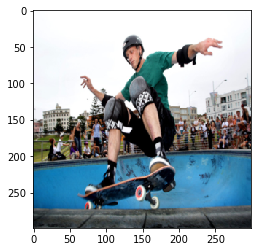

In [0]:
plt.imshow(img)

In [0]:
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

a man riding a skateboard on a ramp .
a man jumping up in the air while riding a skateboard .
a man is jumping in the air on his skateboard .
a man riding a skateboard on a ramp .
a man riding a skateboard on a ramp .
a man riding a skateboard up a ramp .
a man riding a skateboard on a ramp .
a man riding a skateboard on a ramp .
a man riding a skateboard on a ramp .
a man riding a skateboard on a ramp .


--2019-05-05 17:42:59--  http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Resolving ccanimalclinic.com (ccanimalclinic.com)... 23.185.0.2, 2620:12a:8001::2, 2620:12a:8000::2
Connecting to ccanimalclinic.com (ccanimalclinic.com)|23.185.0.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106870 (104K) [image/jpeg]
Saving to: 'caption_data/data/img.jpg'

caption_data/data/i 100%[===================>] 104.37K  --.-KB/s    in 0.1s    

2019-05-05 17:42:59 (927 KB/s) - 'caption_data/data/img.jpg' saved [106870/106870]



/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  This is separate from the ipykernel package so we can avoid doing imports until


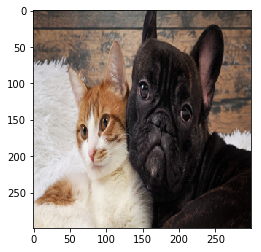

a black and white cat laying on top of a wooden floor .
a black and white dog laying on a couch .
a black and white cat laying on top of a couch .
a black and white cat sitting on a couch .
a black and white cat laying on a couch .
a dog is sitting on the floor next to a book .
a cat is laying on the floor in front of a television .
a black and white dog laying on a couch .
a cat laying on a couch with a book .
a cat is sitting on a chair with a book .


In [0]:
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O caption_data/data/img.jpg
img = plt.imread('caption_data/data/img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

# Demo
### Протестируйте модель как минимум на 10 картинках.

* Убедитесь, что все работает на __простых__ изображениях
* На определенных картинках модель будет фейлиться, это нормально.
* Используйте фотографии, не анимации/3d/рисунки, если только вы не хотите обучить CNN на картинках из мультиков
* Выбирайте квадратные изображения

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  after removing the cwd from sys.path.


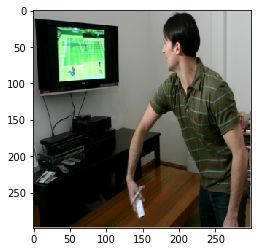

a man is playing a video game in a living room .
a man playing wii while a woman looks on .
a man is playing a video game in a living room .
a man is playing with a video game controller .
a man is playing a video game in a room .
a man is playing a video game in a living room .
a man is playing a video game in a living room .
a man is playing a video game in a living room .
a man standing in a living room playing a game .
a man standing in a living room playing a game controller .


In [0]:
# apply your network on images you've found
#
img = plt.imread('caption_data/data/tv.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  after removing the cwd from sys.path.


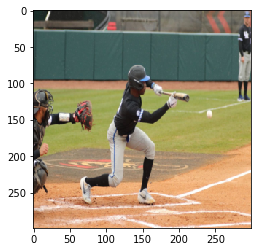

a baseball player holding a bat on a field .
a baseball player is swinging a bat at a ball .
a baseball player in a baseball uniform is swinging a bat .
a baseball player swinging a bat at a ball .
a baseball player swinging a bat at a ball .
a baseball player is swinging a bat at a ball .
a baseball player is swinging a bat at a ball .
a baseball player swinging a bat at a ball .
a baseball player swings his bat at a ball .
a baseball player swinging a bat at a ball .


In [0]:
# apply your network on images you've found
#
img = plt.imread('caption_data/data/baseball.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  after removing the cwd from sys.path.


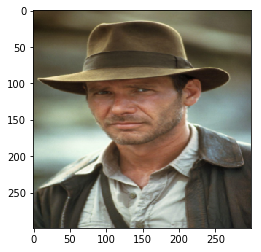

a man wearing a hat and a hat and a hat .
a man wearing a hat and a hat and a hat .
a man in a suit and tie standing next to a man .
a man wearing a hat and a hat and a hat
a man wearing a hat and a hat .
a man wearing a hat and a hat and a hat .
a man wearing a hat and a hat .
a man wearing a hat and a hat with a hat .
a man wearing a hat and a hat and a hat .
a man in a suit and tie standing next to a man .


In [0]:
# apply your network on images you've found
#
img = plt.imread('caption_data/data/hat.png')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  after removing the cwd from sys.path.


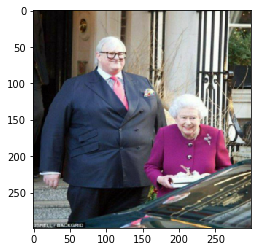

a man and a woman standing next to each other .
a man and a woman are sitting on a bench .
a man and woman are sitting on the ground .
a man and a woman standing next to each other .
a man and a woman are standing next to each other .
a man and a woman standing next to each other .
a man and a woman standing next to each other .
a man and woman are sitting on a bench .
a man and a woman standing next to each other .
a man and a woman standing next to each other .


In [0]:
# apply your network on images you've found
#
img = plt.imread('caption_data/data/img8.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))
    